In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hand-detection/README.dataset.txt
/kaggle/input/hand-detection/README.roboflow.txt
/kaggle/input/hand-detection/data.yaml
/kaggle/input/hand-detection/valid/labels/CARDS_OFFICE_H_T_frame_1168_jpg.rf.0938e5caaa7c95281d2642b7cf783609.txt
/kaggle/input/hand-detection/valid/labels/JENGA_COURTYARD_H_B_frame_2228_jpg.rf.d9fcf60307094fee8a54beab76aef378.txt
/kaggle/input/hand-detection/valid/labels/PUZZLE_OFFICE_T_S_frame_0082_jpg.rf.68bb70fa80e22986cadf4b14934cd359.txt
/kaggle/input/hand-detection/valid/labels/PUZZLE_OFFICE_T_S_frame_0981_jpg.rf.bb291ac5aaa52997e94fadd6f85be383.txt
/kaggle/input/hand-detection/valid/labels/JENGA_COURTYARD_H_B_frame_0684_jpg.rf.2a6da50a782dac015f51b068f7e00e48.txt
/kaggle/input/hand-detection/valid/labels/PUZZLE_COURTYARD_T_H_frame_0499_jpg.rf.1c7545d3eaba5c32d57f1ca0e2737296.txt
/kaggle/input/hand-detection/valid/labels/CARDS_LIVINGROOM_T_B_frame_0478_jpg.rf.5bd1073d7ca0b4cfd7be88a9ab2aa673.txt
/kaggle/input/hand-detection/valid/labels/CARDS_CO

In [2]:
!pip install ultralytics 



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00


In [3]:
import os
from pathlib import Path
from IPython.display import Image, display
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
print("✓ Packages installed successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Packages installed successfully!


In [4]:
!ls /kaggle/input/

hand-detection


In [5]:
DATASET_NAME = 'hand-detection'  
# Define paths
dataset_zip_path = f'/kaggle/input/hand-detection'
extract_path = '/kaggle/working/asl_dataset'

# Check if zip file exists
if os.path.exists(dataset_zip_path):
    print(f"✓ Found dataset at: {dataset_zip_path}")
else:
    print(f"✗ Dataset not found at: {dataset_zip_path}")
    print("\nPlease check:")
    print("1. You've uploaded the dataset to Kaggle")
    print("2. You've added it to this notebook using 'Add Data'")
    print("3. The DATASET_NAME variable matches your dataset folder name")

✓ Found dataset at: /kaggle/input/hand-detection


In [6]:
dataset_path = f'/kaggle/input/{DATASET_NAME}'

print("Checking dataset structure...")
!ls {dataset_path}

print("\nDataset is ready to use!")

Checking dataset structure...
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid

Dataset is ready to use!


In [7]:
# Fix data.yaml with absolute paths
import yaml
import os

# Read the original data.yaml
yaml_path = os.path.join(dataset_path, 'data.yaml')
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Update paths to absolute paths
data['train'] = os.path.join(dataset_path, 'train/images')
data['val'] = os.path.join(dataset_path, 'valid/images')
data['test'] = os.path.join(dataset_path, 'test/images')

# Save the corrected data.yaml to working directory
output_yaml = '/kaggle/working/data.yaml'
with open(output_yaml, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print("="*70)
print("✓ Fixed data.yaml created!")
print("="*70)
print("\nNew data.yaml content:")
print("-"*70)
with open(output_yaml, 'r') as f:
    print(f.read())
print("-"*70)
print(f"\n✓ Saved to: {output_yaml}")
print("\nDataset Info:")
print(f"  Classes: {data['nc']}")
print(f"  Names: {data['names']}")
print(f"  Train images: {data['train']}")
print(f"  Valid images: {data['val']}")
print(f"  Test images: {data['test']}")
print("="*70)


✓ Fixed data.yaml created!

New data.yaml content:
----------------------------------------------------------------------
names:
- myleft
- myright
- yourleft
- yourright
nc: 4
roboflow:
  license: CC BY 4.0
  project: egohands-public
  url: https://universe.roboflow.com/brad-dwyer/egohands-public/dataset/1
  version: 1
  workspace: brad-dwyer
test: /kaggle/input/hand-detection/test/images
train: /kaggle/input/hand-detection/train/images
val: /kaggle/input/hand-detection/valid/images

----------------------------------------------------------------------

✓ Saved to: /kaggle/working/data.yaml

Dataset Info:
  Classes: 4
  Names: ['myleft', 'myright', 'yourleft', 'yourright']
  Train images: /kaggle/input/hand-detection/train/images
  Valid images: /kaggle/input/hand-detection/valid/images
  Test images: /kaggle/input/hand-detection/test/images


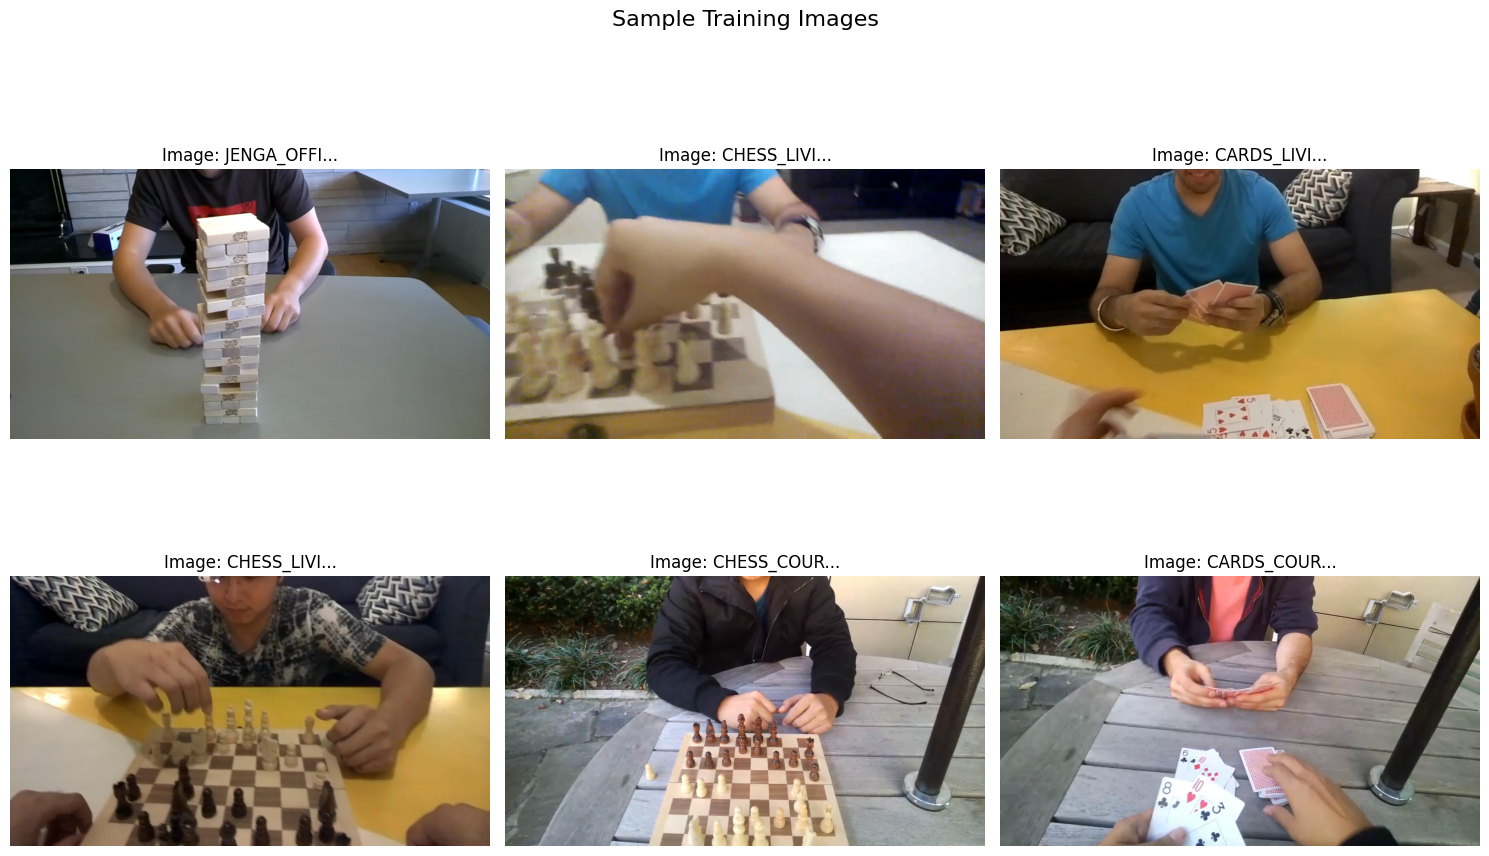

In [8]:
import random
import cv2
from matplotlib import pyplot as plt

# Get sample images from training set
train_images_path = os.path.join(dataset_path, 'train', 'images')
sample_images = random.sample(os.listdir(train_images_path), 6)

# Display samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Training Images', fontsize=16)

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(train_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    ax.set_title(f"Image: {img_name[:10]}...")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
MODEL_SIZE = 'yolo11n.pt'  # Change to yolo11s.pt, yolo11m.pt for better accuracy
EPOCHS = 100                # Increase to 100+ for better results
IMG_SIZE = 640             # Image size for training
BATCH_SIZE = 16            # Reduce to 8 if you get memory errors

print(f"Training Configuration:")
print("="*50)
print(f"Model: {MODEL_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Dataset: {yaml_path}")

Training Configuration:
Model: yolo11n.pt
Epochs: 100
Image Size: 640
Batch Size: 16
Dataset: /kaggle/input/hand-detection/data.yaml


In [10]:
from ultralytics import YOLO

# Initialize YOLO model
model = YOLO(MODEL_SIZE)

print("✓ Model loaded successfully!")
print(f"Starting training for {EPOCHS} epochs...")
print("="*70)

✓ Model loaded successfully!
Starting training for 100 epochs...


In [11]:
results = model.train(
    data=yaml_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name='hands_yolo11',
    patience=10,           
    save=True,            
    device=0,              
    workers=2,             
    verbose=True,          
    plots=True          
)

print("\n" + "="*70)
print("✓ Training completed successfully!")
print("="*70)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/hand-detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=hands_yolo11, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10,

In [12]:
# Best model (use this one!)
best_model = '/kaggle/working/runs/detect/hands_yolo11/weights/best.pt'

# Last checkpoint
last_model = '/kaggle/working/runs/detect/hands_yolo11/weights/last.pt'

In [13]:
import shutil
import os

# Create a clean folder in outputs
os.makedirs('/kaggle/working/saved_models', exist_ok=True)

# Copy your best model
shutil.copy(
    '/kaggle/working/runs/detect/hands_yolo11/weights/best.pt',
    '/kaggle/working/saved_models/hands_best.pt'
)

print("✓ Model saved to: /kaggle/working/saved_models/hands_best.pt")
print("✓ Will appear in Output tab after session ends")

✓ Model saved to: /kaggle/working/saved_models/hands_best.pt
✓ Will appear in Output tab after session ends


In [14]:


!find /kaggle/working -name best.pt


/kaggle/working/runs/detect/hands_yolo11/weights/best.pt
